# Capitulo 2. Proyecto de Machine Learning

👀: verifica que si hayas instalado las librerías que vas a necesitar

En este caso se realizará un modelo para predecir la media de precios en las viviendas de los diferentes municipos de Londres, Reino Unido 🇬🇧.

## <span style="color:green">1. Descargar los datos</span>

Las bases de datos para este proyecto se puede encontrar en este enlace: https://www.kaggle.com/justinas/housing-in-london

También se pueden consultar todas las bases de datos de este curso en GitHub:https://github.com/a2Proyectos/MachineLearning_Data

- housing_in_london_yearly_variables.csv, con los datos que necesitamos para hacer la regresión.
- London_Borough_Excluding_MHW.shp, con los datos que necesitamos para graficar Londres.
- Capitulo_2/housing_in_london_monthly_variables.csv, con los datos de la media salarial

In [1]:
## Importamos nuestras librerias principales panda, numpy, matplotlib, os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
pd.options.display.max_columns = 20


In [2]:
import kagglehub

# Download latest version
path1 = kagglehub.dataset_download("imanollaconcha/barcelona-fotocasa-housingprices")

print("Path to dataset files:", path1)

C:\Users\Abri\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Abri\.cache\kagglehub\datasets\imanollaconcha\barcelona-fotocasa-housingprices\versions\1


In [3]:
os.listdir(path1)

['Barcelona_Fotocasa_HousingPrices.csv']

***

## <span style="color:green">2. Vistazo a la Base de Datos</span>

In [4]:
import pandas as pd
import os

country_file = os.path.join(path1, 'Barcelona_Fotocasa_HousingPrices.csv')

Barcelona_Housing = pd.read_csv(country_file)

Barcelona_Salary = pd.read_csv("2022_renda_disponible_llars_per_persona.csv")

In [5]:
import pandas as pd
import numpy as np # Importamos numpy para el reemplazo condicional

# Asumimos que tu DataFrame se llama df_housing

# 1. Renombrar la columna 'neighborhood' a 'distrito' y pasarla a minúsculas
Barcelona_Housing = Barcelona_Housing.rename(columns={'neighborhood': 'distrito'})
Barcelona_Housing['distrito'] = Barcelona_Housing['distrito'].str.lower().str.strip()

# 2. Corregir inconsistencias de formato (la limpieza es el mapeo)
Barcelona_Housing['distrito'] = Barcelona_Housing['distrito'].str.replace('-', '', regex=False).str.replace(' ', '', regex=False)

# Usamos un diccionario de corrección específico para tu dataset:
correcciones = {
    'hortaguinardo': 'horta-guinardó', # Horta- Guinardo
    'sarriasantgervasi': 'sarrià-sant gervasi', # Sarria-Sant Gervasi
    'santsmontjuic': 'sants-montjuïc', # Si hay esta variación (Sants-Montjuïc)
    'lescorts': 'les corts' # Si hay esta variación
    # Añade aquí cualquier otra corrección que encuentres, como 'ciutatvella'
}

# Aplicamos las correcciones conocidas
Barcelona_Housing['distrito'] = Barcelona_Housing['distrito'].replace(correcciones, regex=True)


# 3. Verificación de las primeras filas
print("--- DataFrame con la columna 'distrito' limpia ---")
print(Barcelona_Housing[['distrito', 'square_meters_price']].head())

print("\n--- Conteo de Valores (Verificación) ---")
print(Barcelona_Housing['distrito'].value_counts())

--- DataFrame con la columna 'distrito' limpia ---
         distrito  square_meters_price
0  horta-guinardó            12.500000
1      santandreu            13.050847
2          gràcia            43.333333
3     ciutatvella            40.000000
4      santandreu            16.363636

--- Conteo de Valores (Verificación) ---
distrito
eixample               2401
sarrià-sant gervasi    1396
ciutatvella            1365
gràcia                  688
santmartí               617
santsmontjuïc           590
les corts               524
horta-guinardó          315
santandreu              178
noubarris               114
Name: count, dtype: int64


In [6]:
# 1. Normalizar completamente el contenido de la columna 'distrito'

# Este paso asegura que nombres como 'ciutatvella' (head) y 'ciutatvella' (value_counts) sean idénticos
Barcelona_Housing['distrito'] = Barcelona_Housing['distrito'].replace({
    'ciutatvella': 'ciutat vella', # Ya limpio
    'eixample': 'eixample', # Ya limpio
    'santsmontjuic': 'sants-montjuïc',
    'lescorts': 'les corts',
    'sarriasantgervasi': 'sarrià-sant gervasi',
    'gracia': 'gràcia',
    'hortaguinardo': 'horta-guinardó',
    'noubarris': 'nou barris',
    'santandreu': 'sant andreu',
    'santmarti': 'sant martí'
})

print("\n--- Conteo de Valores (NORMALIZADO) ---")
print(Barcelona_Housing['distrito'].value_counts())


--- Conteo de Valores (NORMALIZADO) ---
distrito
eixample               2401
sarrià-sant gervasi    1396
ciutat vella           1365
gràcia                  688
santmartí               617
santsmontjuïc           590
les corts               524
horta-guinardó          315
sant andreu             178
nou barris              114
Name: count, dtype: int64


In [7]:
print(Barcelona_Salary.columns.tolist())

['Any', 'Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'Nom_Barri', 'Seccio_Censal', 'Import_Euros']


In [8]:
import pandas as pd

# Suponiendo que el DataFrame de salario ya está cargado
# Barcelona_Salary = pd.read_csv("2022_renda_disponible_llars_per_persona.csv")

# 1. Definición del Mapeo de Barrio a Distrito (Nombres en catalán/oficiales)
barrio_a_distrito_map = {
    # Distrito 01: Ciutat Vella
    'el raval': 'ciutat vella',
    'barri gòtic': 'ciutat vella',
    'la barceloneta': 'ciutat vella',
    'sant pere, santa caterina i la ribera': 'ciutat vella',
    
    # Distrito 02: Eixample
    'el fort pienc': 'eixample',
    'sagrada família': 'eixample',
    'dreta de l\'eixample': 'eixample',
    'l\'antiga esquerra de l\'eixample': 'eixample',
    'la nova esquerra de l\'eixample': 'eixample',
    'sant antoni': 'eixample',
    
    # Distrito 03: Sants-Montjuïc
    'el poble-sec': 'sants-montjuïc',
    'la marina del prat vermell': 'sants-montjuïc',
    'la marina de port': 'sants-montjuïc',
    'la font de la guatlla': 'sants-montjuïc',
    'hostafrancs': 'sants-montjuïc',
    'la bordeta': 'sants-montjuïc',
    'sants-badal': 'sants-montjuïc',
    'sants': 'sants-montjuïc',
    'zona franca - port': 'sants-montjuïc', # A veces incluido
    'parc de montjuïc': 'sants-montjuïc', # A veces incluido
    
    # Distrito 04: Les Corts
    'les corts': 'les corts',
    'la maternitat i sant ramon': 'les corts',
    'pedralbes': 'les corts',
    
    # Distrito 05: Sarrià-Sant Gervasi
    'vallvidrera, el tibidabo i les planes': 'sarrià-sant gervasi',
    'sarrià': 'sarrià-sant gervasi',
    'les tres torres': 'sarrià-sant gervasi',
    'sant gervasi - la bonanova': 'sarrià-sant gervasi',
    'sant gervasi - galvany': 'sarrià-sant gervasi',
    'el putxet i el farró': 'sarrià-sant gervasi',
    
    # Distrito 06: Gràcia
    'vallcarca i els penitents': 'gràcia',
    'el coll': 'gràcia',
    'la salut': 'gràcia',
    'vila de gràcia': 'gràcia',
    'camp d\'en grassot i gràcia nova': 'gràcia',
    
    # Distrito 07: Horta-Guinardó
    'baix guinardó': 'horta-guinardó',
    'can baró': 'horta-guinardó',
    'el guinardó': 'horta-guinardó',
    'la font d\'en fargues': 'horta-guinardó',
    'el carmel': 'horta-guinardó',
    'la teixonera': 'horta-guinardó',
    'sant genís dels agudells': 'horta-guinardó',
    'montbau': 'horta-guinardó',
    'la vall d\'hebron': 'horta-guinardó',
    'la clota': 'horta-guinardó',
    'horta': 'horta-guinardó',
    
    # Distrito 08: Nou Barris
    'vilapicina i la torre llobeta': 'nou barris',
    'porta': 'nou barris',
    'el turó de la peira': 'nou barris',
    'can peguera': 'nou barris',
    'la guineueta': 'nou barris',
    'canyelles': 'nou barris',
    'les roquetes': 'nou barris',
    'verdum': 'nou barris',
    'la prosperitat': 'nou barris',
    'la trinitat nova': 'nou barris',
    'torre baró': 'nou barris',
    'ciutat meridiana': 'nou barris',
    'vallbona': 'nou barris',
    
    # Distrito 09: Sant Andreu
    'la trinitat vella': 'sant andreu',
    'baró de viver': 'sant andreu',
    'el bon pastor': 'sant andreu',
    'sant andreu de palomar': 'sant andreu',
    'la sagrera': 'sant andreu',
    'el congrés i els indians': 'sant andreu',
    'navas': 'sant andreu',
    
    # Distrito 10: Sant Martí
    'el camp de l\'arpa del clot': 'sant martí',
    'el clot': 'sant martí',
    'el parc i la llacuna del poblenou': 'sant martí',
    'la vila olímpica del poblenou': 'sant martí',
    'el poblenou': 'sant martí',
    'diagonal mar i el front marítim del poblenou': 'sant martí',
    'el besòs i el maresme': 'sant martí',
    'provençals del poblenou': 'sant martí',
    'sant martí de provençals': 'sant martí',
    'la verneda i la pau': 'sant martí'
}

# 2. Asumir el nombre de la columna y normalizar
# **¡IMPORTANTE!** Reemplaza 'Nom_Barri_a_Corregir' con el nombre real de tu columna de barrios.
nombre_columna_barrio = 'Nom_Districte' 

# Normalizar la columna para asegurar la coincidencia
Barcelona_Salary['barrio_limpio'] = (
    Barcelona_Salary[nombre_columna_barrio]
    .str.lower()
    .str.strip()
)

# 3. Aplicar el mapeo
Barcelona_Salary['Distrito'] = Barcelona_Salary['barrio_limpio'].map(barrio_a_distrito_map)

# 4. Verificación
print("--- Vista Previa con la Columna 'Distrito' Añadida ---")
print(Barcelona_Salary[['Nom_Districte', 'Distrito']].head())

print("\n--- Barrios que NO se pudieron mapear (NaN) ---")
# Esto te ayuda a encontrar errores o inconsistencias en los nombres
barrios_no_mapeados = Barcelona_Salary[Barcelona_Salary['Distrito'].isna()][nombre_columna_barrio].unique()
if len(barrios_no_mapeados) > 0:
    print(barrios_no_mapeados)
else:
    print("¡Todos los barrios se mapearon correctamente!")

# Puedes eliminar la columna temporal si lo deseas:
# Barcelona_Salary = Barcelona_Salary.drop(columns=['barrio_limpio'])

--- Vista Previa con la Columna 'Distrito' Añadida ---
  Nom_Districte Distrito
0  Ciutat Vella      NaN
1  Ciutat Vella      NaN
2  Ciutat Vella      NaN
3  Ciutat Vella      NaN
4  Ciutat Vella      NaN

--- Barrios que NO se pudieron mapear (NaN) ---
['Ciutat Vella' 'Eixample' 'Sants-Montjuïc' 'Sarrià-St. Gervasi' 'Gràcia'
 'Horta-Guinardó' 'Nou Barris' 'Sant Andreu' 'Sant Martí']


In [9]:
Barcelona_Salary["Nom_Districte"].value_counts()


Nom_Districte
Eixample              173
Sant Martí            147
Horta-Guinardó        123
Sants-Montjuïc        117
Nou Barris            117
Sarrià-St. Gervasi     98
Sant Andreu            95
Gràcia                 87
Les Corts              57
Ciutat Vella           54
Name: count, dtype: int64

In [10]:
Barcelona_Salary.rename(columns={
    "Any": "Year",
    "Codi_Districte": "District_Code",
    "Nom_Districte": "distrito",
    "Codi_Barri": "Neighborhood_Code",
    "Nom_Barri": "nom_barrio",
    "Seccio_Censal": "Census_Section",
    "Import_Euros": "Income_Euros"
}, inplace=True)

Barcelona_Housing.rename(columns={
    "price": "Price",
    "rooms": "Rooms",
    "bathroom": "Bathrooms",
    "lift": "Lift",
    "terrace": "Terrace",
    "square_meters": "Square_Meters",
    "real_state": "Property_Type",
    "neighborhood": "distrito",
    "square_meters_price": "Price_per_m2"
}, inplace=True)

In [11]:
# Limpiar nombres de barrios 
Barcelona_Salary["distrito"] = Barcelona_Salary["distrito"].str.strip().str.lower()
Barcelona_Housing["distrito"] = Barcelona_Housing["distrito"].str.strip().str.lower()

In [12]:
data = Barcelona_Salary.merge(Barcelona_Housing, on="distrito", how="left")
data

,Year,District_Code,distrito,Neighborhood_Code,nom_barrio,Census_Section,Income_Euros,barrio_limpio,Distrito,Unnamed: 0,Price,Rooms,Bathrooms,Lift,Terrace,Square_Meters,Property_Type,Price_per_m2
0,2022,1,ciutat vella,1,el Raval,1,15940,ciutat vella,NaN,3.0,2800.0,1.0,1.0,True,True,70.0,flat,40.000000
1,2022,1,ciutat vella,1,el Raval,1,15940,ciutat vella,NaN,49.0,850.0,1.0,1.0,False,False,45.0,flat,18.888889
2,2022,1,ciutat vella,1,el Raval,1,15940,ciutat vella,NaN,51.0,1580.0,3.0,2.0,True,True,110.0,flat,14.363636
3,2022,1,ciutat vella,1,el Raval,1,15940,ciutat vella,NaN,53.0,1350.0,1.0,1.0,True,True,60.0,attic,22.500000
4,2022,1,ciutat vella,1,el Raval,1,15940,ciutat vella,NaN,60.0,2550.0,2.0,2.0,True,False,137.0,flat,18.613139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648157,2022,10,sant martí,73,la Verneda i la Pau,143,16402,sant martí,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
648158,2022,10,sant martí,65,el Clot,234,21047,sant martí,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
648159,2022,10,sant martí,69,Diagonal Mar i el Front Marítim del Poblenou,235,18576,sant martí,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
648160,2022,10,sant martí,69,Diagonal Mar i el Front Marítim del Poblenou,236,19369,sant martí,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Obtener información de los datos.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648162 entries, 0 to 648161
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               648162 non-null  int64  
 1   District_Code      648162 non-null  int64  
 2   distrito           648162 non-null  object 
 3   Neighborhood_Code  648162 non-null  int64  
 4   nom_barrio         648162 non-null  object 
 5   Census_Section     648162 non-null  int64  
 6   Income_Euros       648162 non-null  int64  
 7   barrio_limpio      648162 non-null  object 
 8   Distrito           29868 non-null   object 
 9   Unnamed: 0         647800 non-null  float64
 10  Price              647800 non-null  float64
 11  Rooms              647800 non-null  float64
 12  Bathrooms          647800 non-null  float64
 13  Lift               647800 non-null  object 
 14  Terrace            647800 non-null  object 
 15  Square_Meters      647800 non-null  float64
 16  Pr

In [14]:
data["distrito"].value_counts()


distrito
eixample              415373
ciutat vella           73710
gràcia                 59856
horta-guinardó         38745
les corts              29868
sant andreu            16910
nou barris             13338
sant martí               147
sants-montjuïc           117
sarrià-st. gervasi        98
Name: count, dtype: int64

👀:Comienza a ver el tipo de variable, de eso depende el análisis que le demos o si necesitamos cambiarlas a otro tipo de variable

***

In [15]:
# Una forma muy común para saber que tipo de datos contiene alguna variable de tipo objeto, es contar sus valores, ejemplo:
data["distrito"].value_counts()


distrito
eixample              415373
ciutat vella           73710
gràcia                 59856
horta-guinardó         38745
les corts              29868
sant andreu            16910
nou barris             13338
sant martí               147
sants-montjuïc           117
sarrià-st. gervasi        98
Name: count, dtype: int64

In [16]:
# Una forma muy común para saber que tipo de datos contiene alguna variable de tipo objeto, es contar sus valores, ejemplo:
data["distrito"].value_counts()


distrito
eixample              415373
ciutat vella           73710
gràcia                 59856
horta-guinardó         38745
les corts              29868
sant andreu            16910
nou barris             13338
sant martí               147
sants-montjuïc           117
sarrià-st. gervasi        98
Name: count, dtype: int64

In [17]:
# Una forma muy utilizada para obtener información de nuestros datos numéricos es el método describe(), ejemplo:
pd.options.display.float_format = "{:,.2f}".format
data.describe()

,Year,District_Code,Neighborhood_Code,Census_Section,Income_Euros,Unnamed: 0,Price,Rooms,Bathrooms,Square_Meters,Price_per_m2
count,"648,162.00","648,162.00","648,162.00","648,162.00","648,162.00","647,800.00","647,800.00","647,800.00","647,800.00","647,800.00","647,800.00"
mean,"2,022.00",2.96,13.69,70.72,"24,436.80","4,157.68","1,436.02",2.45,1.49,82.89,18.13
std,0.00,2.10,13.63,48.59,"4,789.36","2,361.56","1,044.97",1.11,0.66,40.00,10.46
min,"2,022.00",1.00,1.00,1.00,"9,572.00",0.00,423.00,0.00,1.00,15.00,6.57
25%,"2,022.00",2.00,6.00,30.00,"22,039.00","2,082.00",900.00,2.00,1.00,60.00,12.71
50%,"2,022.00",2.00,8.00,60.00,"24,597.00","4,160.00","1,150.00",2.00,1.00,75.00,15.15
75%,"2,022.00",2.00,10.00,109.00,"26,853.00","6,218.00","1,500.00",3.00,2.00,95.00,19.83
max,"2,022.00",10.00,73.00,237.00,"43,325.00","8,187.00","15,000.00",10.00,8.00,429.00,186.67


In [18]:
columns_of_interest = [
    "distrito",
    "Year",
    "Income_Euros",
    "Price",
    "Square_Meters",
    "Price_per_m2",
    "Rooms",
    "Bathrooms",
    "Lift",
    "Terrace",
    "Property_Type"
]

df_filtered = data[columns_of_interest]

# Revisamos las primeras filas
df_filtered.head()

,distrito,Year,Income_Euros,Price,Square_Meters,Price_per_m2,Rooms,Bathrooms,Lift,Terrace,Property_Type
0,ciutat vella,2022,15940,"2,800.00",70.00,40.00,1.00,1.00,True,True,flat
1,ciutat vella,2022,15940,850.00,45.00,18.89,1.00,1.00,False,False,flat
2,ciutat vella,2022,15940,"1,580.00",110.00,14.36,3.00,2.00,True,True,flat
3,ciutat vella,2022,15940,"1,350.00",60.00,22.50,1.00,1.00,True,True,attic
4,ciutat vella,2022,15940,"2,550.00",137.00,18.61,2.00,2.00,True,False,flat


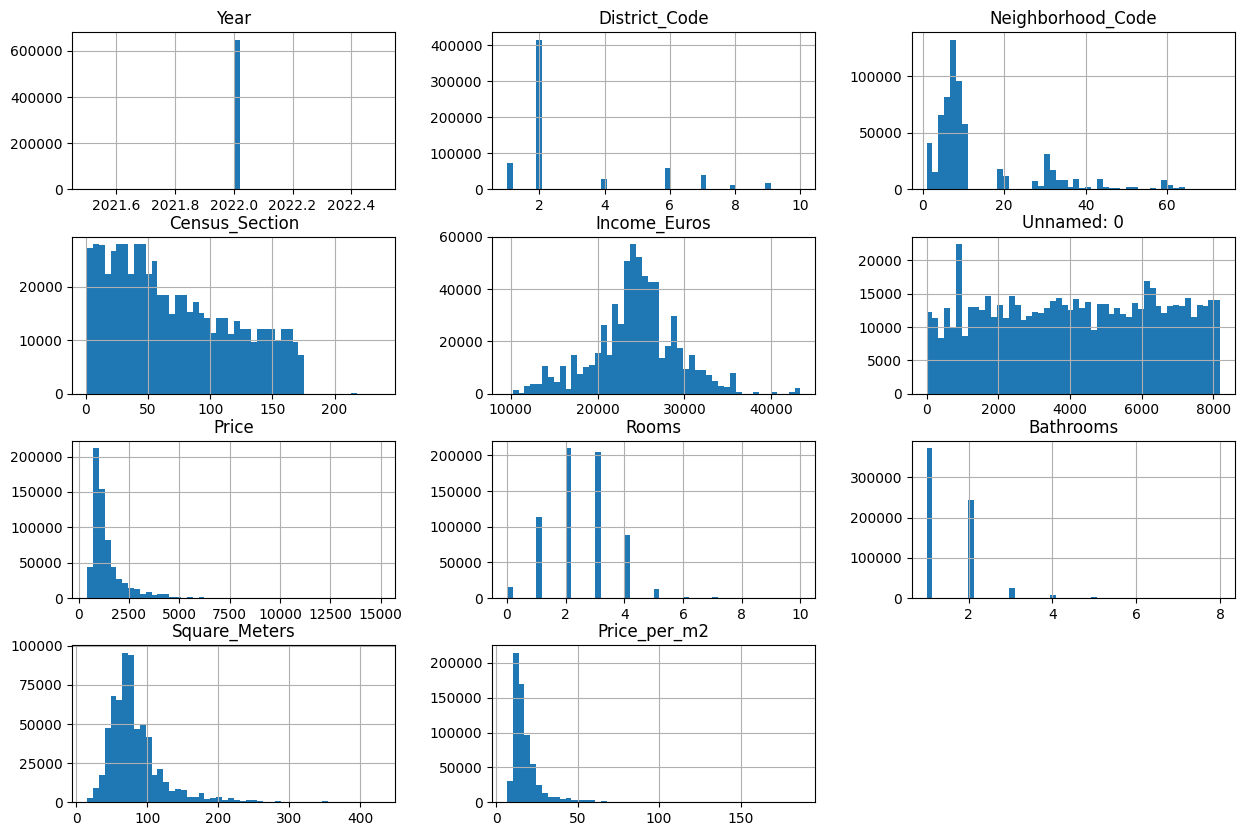

In [19]:
# Realiza un Histograma para visualizar los datos 
#matplotlib inline para aquellos que estan con jupyter notebook
data.hist(bins=50, figsize=(15,10))
plt.show()

***

## <span style="color:green">3. Crear un set de entrenamiento y de prueba </span>

Recuerden que nuestro set de prueba lo pondremos de lado por ahora, sin verlo. No sean tramposos ❌

In [20]:
#Importamos la función para dividir los datos train_test_split
from sklearn.model_selection import train_test_split

In [21]:
# Seleccionamos por ejemplo, el 30% de los datos para el set de prueba
#Random_state es la semilla que se usa para generar números aleatorios.
set_ent, set_prueba = train_test_split(df_filtered,test_size=0.3,random_state=11)


In [22]:
#confirmamos la división
print(len(set_ent),len(set_prueba))

453713 194449


Ya tenemos nuestro set de prueba y nuestro set de entrenamiento ✅

***

### <span style="color:blue">3.1 Evitar Sesgo </span>

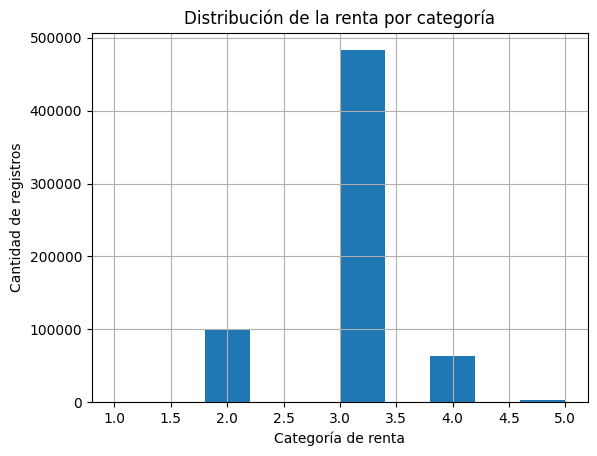

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Crear categorías de renta
data["income_cat"] = pd.cut(
    data["Income_Euros"],       # variable continua
    bins=[0, 10000, 20000, 30000, 40000, np.inf],   # 5 niveles
    labels=[1, 2, 3, 4, 5]
)

# Histograma de categorías
data["income_cat"].hist()
plt.title("Distribución de la renta por categoría")
plt.xlabel("Categoría de renta")
plt.ylabel("Cantidad de registros")
plt.show()



In [24]:
#Verificar que no existen datos en el bin #1
data["income_cat"].value_counts()

income_cat
3    482935
2     98939
4     63116
5      3171
1         1
Name: count, dtype: int64

<Axes: >

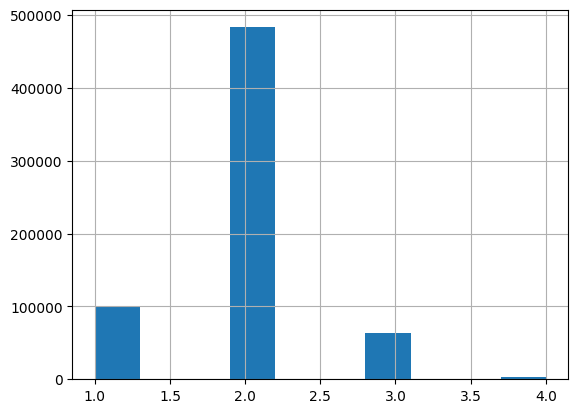

In [25]:
# Redefinir en 4 categorías, quitando en donde no hay datos (el bin#1)
data = data.dropna(subset=["Income_Euros"])
data = data.reset_index()
data["income_cat"] =pd.cut(data["Income_Euros"],bins=[10000,20000,30000,40000,np.inf],labels=[1,2,3,4])
data["income_cat"].hist()

In [26]:
#Verifica que si se redefinieron las categorías 
data["income_cat"].value_counts

<bound method IndexOpsMixin.value_counts of 0         1
1         1
2         1
3         1
4         1
         ..
648157    1
648158    2
648159    1
648160    1
648161    1
Name: income_cat, Length: 648162, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]>

In [27]:
## Dividir datos basándonos en nuestras categorías de salarios
from sklearn.model_selection import StratifiedShuffleSplit


In [28]:
# Generamos nuestro objeto para que lo divida en 30% y solo haga una división
split = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=11)

In [29]:
# Mantener solo categorías con al menos 2 registros
counts = data["income_cat"].value_counts()
valid_categories = counts[counts >= 2].index
data = data[data["income_cat"].isin(valid_categories)]

In [30]:
data = data.reset_index(drop=True)


In [31]:
# Creamos nuestras variables basándonos en nuestras categorías
for ent_index, prueba_index in split.split(data, data["income_cat"]):#Definir de nuevo, entrenamiento y prueba peroteniedno en cuenta las nuevas etiquetas para eliminar sesgo
    cat_set_ent = data.loc[ent_index]
    cat_set_prueba = data.loc[prueba_index]

In [32]:
# Comprobación. Ya en porcentaje
cat_set_prueba["income_cat"].value_counts()/len(cat_set_prueba)

income_cat
2   0.75
1   0.15
3   0.10
4   0.00
Name: count, dtype: float64

***

In [33]:
# Creamos dataframe para trabajar con el set de entrenamiento
# Creamos dataframe para trabajar con el set de entrenamiento
df = cat_set_ent.copy()
df.head()

,index,Year,District_Code,distrito,Neighborhood_Code,nom_barrio,Census_Section,Income_Euros,barrio_limpio,Distrito,Unnamed: 0,Price,Rooms,Bathrooms,Lift,Terrace,Square_Meters,Property_Type,Price_per_m2,income_cat
4470,4470,2022,1,ciutat vella,1,el Raval,4,15749,ciutat vella,NaN,"2,362.00","1,200.00",1.00,1.00,False,False,42.00,flat,28.57,1
556002,556002,2022,6,gràcia,31,la Vila de Gràcia,55,25464,gràcia,NaN,"4,300.00","1,180.00",3.00,2.00,True,False,80.00,flat,14.75,2
26881,26881,2022,1,ciutat vella,1,el Raval,20,19278,ciutat vella,NaN,"6,136.00","2,810.00",3.00,2.00,False,False,120.00,apartment,23.42,1
111902,111902,2022,2,eixample,5,el Fort Pienc,16,26542,eixample,NaN,"7,475.00","2,300.00",6.00,2.00,True,False,195.00,flat,11.79,2
445330,445330,2022,2,eixample,10,Sant Antoni,155,22039,eixample,NaN,"6,446.00","1,050.00",1.00,1.00,True,False,54.00,flat,19.44,2


***

## <span style="color:green">4. Visualizar los Datos Gráficamente </span>


Para esto vamos a necesitar, en conjunto con nuestro dataset LONDON_MAP, una nueva libreria que se llama geopandas, el cual exteiende la libreria pandas, para trabajar con datos geoespaciales, se puede encontrar más información en: https://geopandas.org/getting_started/introduction.html

In [34]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable


In [35]:
import geopandas as gpd

#Leer el mapa
url = 'https://raw.githubusercontent.com/jcanalesluna/bcn-geodata/master/districtes/districtes.geojson'
districts = gpd.read_file(url)

print("Datos cargados correctamente.")
districts.head()


Datos cargados correctamente.


,ID_ANNEX,ANNEXDESCR,ID_TEMA,TEMA_DESCR,ID_CONJUNT,CONJ_DESCR,ID_SUBCONJ,SCONJ_DESC,ID_ELEMENT,ELEM_DESCR,...,ESTIL_ID,ESTIL_QGIS,VALOR1QGIS,VALOR2QGIS,COL_FARCIT,FCOL_DESCR,FHEX_COLOR,COL_DESCR,HEX_COLOR7,geometry
0,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,Límit de districte,...,0,Sòlid,0,0,1,Negre,#000000,Negre,#000000,"POLYGON ((2.18345 41.39061, 2.18459 41.38976, ..."
1,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,Límit de districte,...,0,Sòlid,0,0,1,Negre,#000000,Negre,#000000,"POLYGON ((2.1869 41.40165, 2.18689 41.40087, 2..."
2,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,Límit de districte,...,0,Sòlid,0,0,1,Negre,#000000,Negre,#000000,"MULTIPOLYGON (((2.14824 41.37623, 2.14896 41.3..."
3,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,Límit de districte,...,0,Sòlid,0,0,1,Negre,#000000,Negre,#000000,"POLYGON ((2.10342 41.4011, 2.10352 41.40109, 2..."
4,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,Límit de districte,...,0,Sòlid,0,0,1,Negre,#000000,Negre,#000000,"MULTIPOLYGON (((2.07313 41.43522, 2.07319 41.4..."


In [36]:
print(districts)


  ID_ANNEX ANNEXDESCR ID_TEMA               TEMA_DESCR ID_CONJUNT  CONJ_DESCR  \
0       01   Grup - I    0104  Unitats Administratives     010412  Districtes   
1       01   Grup - I    0104  Unitats Administratives     010412  Districtes   
2       01   Grup - I    0104  Unitats Administratives     010412  Districtes   
3       01   Grup - I    0104  Unitats Administratives     010412  Districtes   
4       01   Grup - I    0104  Unitats Administratives     010412  Districtes   
5       01   Grup - I    0104  Unitats Administratives     010412  Districtes   
6       01   Grup - I    0104  Unitats Administratives     010412  Districtes   
7       01   Grup - I    0104  Unitats Administratives     010412  Districtes   
8       01   Grup - I    0104  Unitats Administratives     010412  Districtes   
9       01   Grup - I    0104  Unitats Administratives     010412  Districtes   

  ID_SUBCONJ SCONJ_DESC  ID_ELEMENT          ELEM_DESCR  ... ESTIL_ID  \
0   01041201  Districte  0104120101

In [37]:
print(districts.columns.tolist())

['ID_ANNEX', 'ANNEXDESCR', 'ID_TEMA', 'TEMA_DESCR', 'ID_CONJUNT', 'CONJ_DESCR', 'ID_SUBCONJ', 'SCONJ_DESC', 'ID_ELEMENT', 'ELEM_DESCR', 'NIVELL', 'NDESCR_CA', 'NDESCR_ES', 'NDESCR_EN', 'TERME', 'DISTRICTE', 'BARRI', 'AEB', 'SEC_CENS', 'GRANBARRI', 'ZUA', 'AREA_I', 'LITERAL', 'PERIMETRE', 'AREA', 'ORD_REPRES', 'CODI_UA', 'TIPUS_UA', 'NOM', 'WEB1', 'WEB2', 'WEB3', 'DOCUMENTA', 'RANGESCALA', 'TIPUS_POL', 'GRUIX_ID', 'GRUIXDIMEN', 'ESTIL_ID', 'ESTIL_QGIS', 'VALOR1QGIS', 'VALOR2QGIS', 'COL_FARCIT', 'FCOL_DESCR', 'FHEX_COLOR', 'COL_DESCR', 'HEX_COLOR7', 'geometry']


<Axes: >

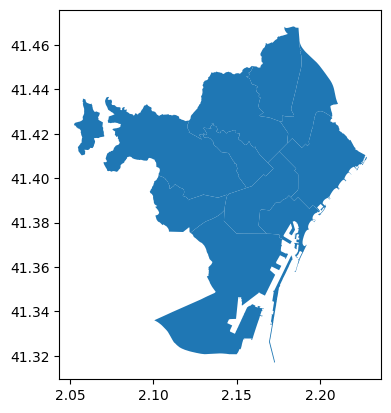

In [38]:
# Graficamos el mapa
districts.plot()

In [39]:
import pandas as pd
import geopandas as gpd

# Definición del mapa de nombres (Formato de Capitalización Deseado)
mapa_nombres = {
    '01': 'ciutat vella',
    '02': 'eixample',
    '03': 'sants-montjuïc',
    '04': 'les corts',
    '05': 'sarrià-sant gervasi',
    '06': 'gràcia',
    '07': 'gorta-guinardó',
    '08': 'nou barris',
    '09': 'sant andreu',
    '10': 'aant martí'
}

# --- CÓDIGO FUNCIONAL ---

# 0. NORMALIZAR: Asegurarse de que todas las columnas, incluida 'DISTRICTE', estén en minúsculas.
districts.columns = districts.columns.str.lower()

# 1. Renombrar la columna del código.
# La columna real es 'districte' (después de aplicar lower).
districts = districts.rename(columns={'districte': 'codi_districte'})


# 2. Mapear el código de distrito para obtener el nombre
# Ahora que 'codi_districte' existe, podemos usarla para crear la columna 'area'.
districts['distrito'] = districts['codi_districte'].astype(str).str.zfill(2).map(mapa_nombres) 

# 3. Seleccionar las columnas clave y el nombre del distrito
districts = districts.filter(items=["distrito", "codi_districte", "id_conjunt", "geometry"])

print("--- GeoDataFrame Arreglado y Nombrado Correctamente ---")
print(districts.head(10))

--- GeoDataFrame Arreglado y Nombrado Correctamente ---
              distrito codi_districte id_conjunt  \
0         ciutat vella             01     010412   
1             eixample             02     010412   
2       sants-montjuïc             03     010412   
3            les corts             04     010412   
4  sarrià-sant gervasi             05     010412   
5               gràcia             06     010412   
6       gorta-guinardó             07     010412   
7           nou barris             08     010412   
8          sant andreu             09     010412   
9           aant martí             10     010412   

                                            geometry  
0  POLYGON ((2.18345 41.39061, 2.18459 41.38976, ...  
1  POLYGON ((2.1869 41.40165, 2.18689 41.40087, 2...  
2  MULTIPOLYGON (((2.14824 41.37623, 2.14896 41.3...  
3  POLYGON ((2.10342 41.4011, 2.10352 41.40109, 2...  
4  MULTIPOLYGON (((2.07313 41.43522, 2.07319 41.4...  
5  POLYGON ((2.13629 41.42363, 2.1364 41.

***

***

In [40]:
# Seleccionar datos de nuestro set de entrenamiento
df_m = df.groupby("distrito").agg({"Income_Euros":["mean"],"Price":"sum"})
df
# Le asignamos nombre a las columnas del nuevo dataframe y reseteamos el indice
df_m.columns = ["Income_Euros", "Price"]
df_m.reset_index(inplace=True)
pd.options.display.max_rows = None
df_m


,distrito,Income_Euros,Price
0,ciutat vella,"17,034.83","62,359,153.00"
1,eixample,"26,007.09","462,478,660.00"
2,gràcia,"25,277.91","49,723,569.00"
3,horta-guinardó,"20,735.09","24,505,921.00"
4,les corts,"29,392.67","33,595,705.00"
5,nou barris,"17,084.90","7,497,482.00"
6,sant andreu,"20,706.81","10,586,061.00"
7,sant martí,"21,238.81",0.00
8,sants-montjuïc,"20,440.76",0.00
9,sarrià-st. gervasi,"35,100.08",0.00


In [41]:
# Combinar dtaframes
districts = pd.merge(districts,df_m,on="distrito")
districts.head()

,distrito,codi_districte,id_conjunt,geometry,Income_Euros,Price
0,ciutat vella,01,010412,"POLYGON ((2.18345 41.39061, 2.18459 41.38976, ...","17,034.83","62,359,153.00"
1,eixample,02,010412,"POLYGON ((2.1869 41.40165, 2.18689 41.40087, 2...","26,007.09","462,478,660.00"
2,sants-montjuïc,03,010412,"MULTIPOLYGON (((2.14824 41.37623, 2.14896 41.3...","20,440.76",0.00
3,les corts,04,010412,"POLYGON ((2.10342 41.4011, 2.10352 41.40109, 2...","29,392.67","33,595,705.00"
4,gràcia,06,010412,"POLYGON ((2.13629 41.42363, 2.1364 41.42358, 2...","25,277.91","49,723,569.00"


***

(np.float64(2.092143437545181),
 np.float64(2.216407557085072),
 np.float64(41.3094755699351),
 np.float64(41.475860544851926))

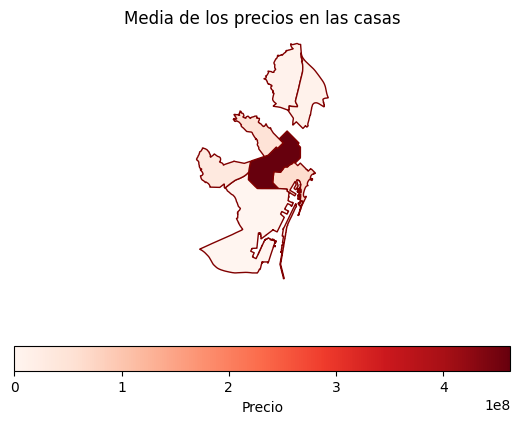

In [42]:
#Gráfica del promedio de los precios en las casas 
#Cuando se grafica en geopandas hay muchos argumentos, no se desesperen si no los recuerdan, es normal. 
plt = districts.plot(column = "Price", #Columna en la que se basa la gráfica
                        cmap = "Reds", #Color gradiente de la gráfica
                        edgecolor="maroon", #Color de contorno
                        legend = True, legend_kwds ={"label":"Precio","orientation":"horizontal"}) #leyenda
plt.set_title("Media de los precios en las casas")
plt.axis("off")

(np.float64(2.092143437545181),
 np.float64(2.216407557085072),
 np.float64(41.3094755699351),
 np.float64(41.475860544851926))

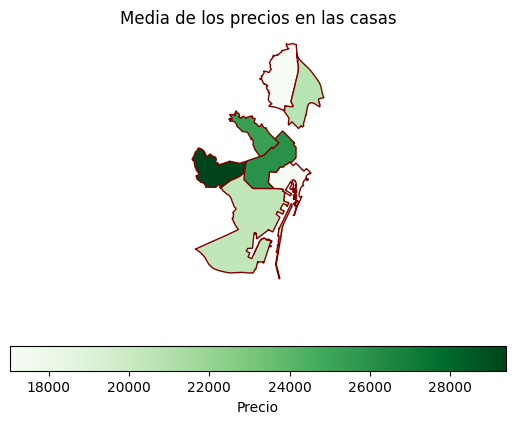

In [43]:
#Gráfica del promedio de los precios en las casas 
#Cuando se grafica en geopandas hay muchos argumentos, no se desesperen si no los recuerdan, es normal. 
plt = districts.plot(column = "Income_Euros", #Columna en la que se basa la gráfica
                        cmap = "Greens", #Color gradiente de la gráfica
                        edgecolor="maroon", #Color de contorno
                        legend = True, legend_kwds ={"label":"Precio","orientation":"horizontal"}) #leyenda
plt.set_title("Media de los precios en las casas")
plt.axis("off")

**Ejercicio:** Incluir en el análisis los salarios promedio por zona (apoyarse del video 21)

***

## <span style="color:green">5. Medir la Correlación </span>


In [44]:
# Crear matriz de correlaciónç
df = df.drop("Year", axis=1)

numeric_df = df.select_dtypes(include=["number"])
matriz = numeric_df.corr(method="pearson") #metodo.corr crea la matriz de correlación y usamos el método pearson que es el más común

# Comparar correlación
matriz["Price"].sort_values(ascending=False)

Price                1.00
Price_per_m2         0.63
Square_Meters        0.56
Bathrooms            0.49
Rooms                0.25
Income_Euros         0.13
Census_Section       0.07
Unnamed: 0           0.01
index               -0.09
District_Code       -0.18
Neighborhood_Code   -0.18
Name: Price, dtype: float64

<Axes: >

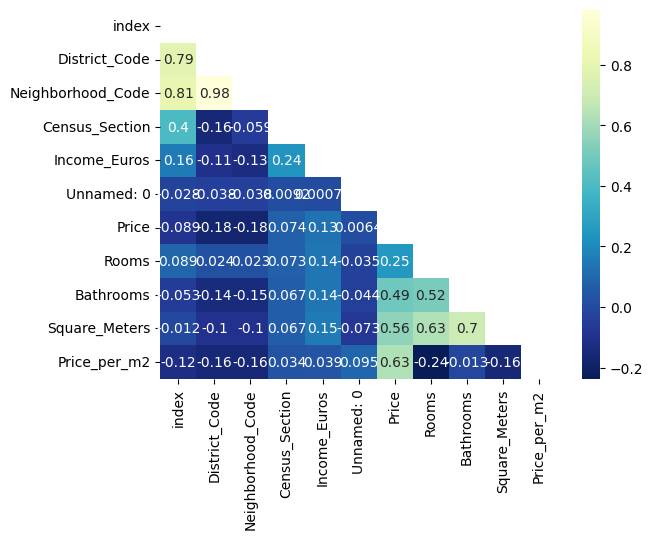

In [45]:
#Importar seaborn 
import seaborn as sb

# Crear vector
mask = np.triu(np.ones_like(matriz, dtype = bool))

# Graficar
plt = sb.heatmap(matriz, mask = mask,annot = True, cmap = "YlGnBu_r")
plt

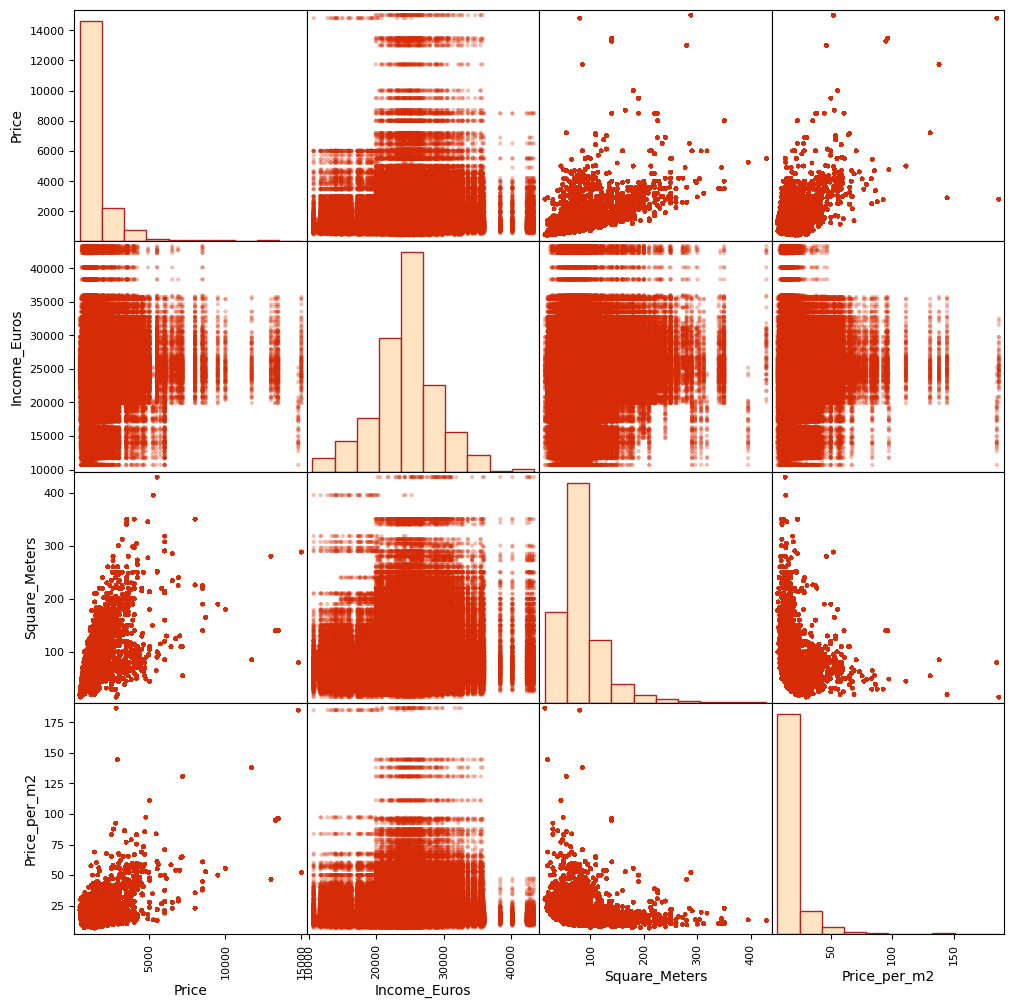

In [46]:
#Importar pandas 
from pandas.plotting import scatter_matrix

#Para graficar scatter_matrix...
columns=["Price","Income_Euros","Square_Meters","Price_per_m2"]
scatter_matrix(df[columns],figsize=(12,12),color = "#D52b06",alpha = 0.3,hist_kwds = {"color":{"bisque"},"edgecolor":"firebrick"});

<Axes: xlabel='Income_Euros', ylabel='Price'>

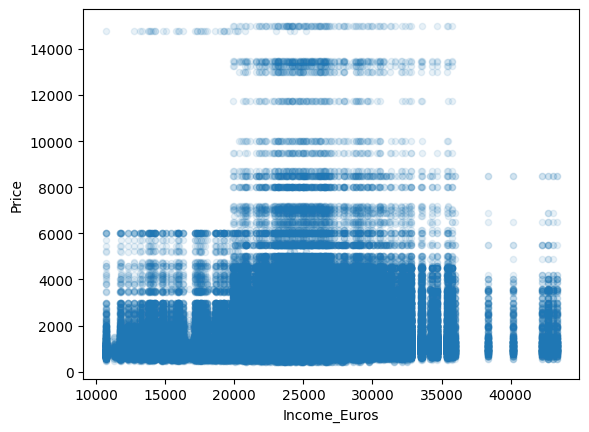

In [47]:
#Por si quieren ver una gráfica en específico más a detalle
df.plot(kind="scatter", x="Income_Euros", y="Price",alpha=0.1)

***

## <span style="color:green">6. Combinación de Variables </span>


In [48]:
#Armar una columna para hacer las combinaciones que necesitamos
df["S_M/Precio"] = df["Income_Euros"] * df ["Price_per_m2"]
# Crear matriz de correlación
numeric_df = df.select_dtypes(include=["number"])
matriz = numeric_df.corr(method="pearson")
matriz["Price"].sort_values(ascending=False)

Price                1.00
Price_per_m2         0.63
S_M/Precio           0.63
Square_Meters        0.56
Bathrooms            0.49
Rooms                0.25
Income_Euros         0.13
Census_Section       0.07
Unnamed: 0           0.01
index               -0.09
District_Code       -0.18
Neighborhood_Code   -0.18
Name: Price, dtype: float64

***

***

## <span style="color:Blue">7. Transformación de Datos </span>


In [49]:
# Crear Dataframe de predictores y variable a predecir ✂️
df_label = cat_set_ent["Price"] #Cojo una sola columna de la cual sacaré las métricas de mis predicciones
#Nuevo dataframe sin average_price
df = cat_set_ent.drop("Price", axis=1) # De la anterior copia saco la average_price que ya tengo en df_label

***

In [50]:
#Darte una idea de a qué variables le hace faltan datos
df.info()
#Calcular la suma de todos los vacíos  
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 453712 entries, 4470 to 304613
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   index              453712 non-null  int64   
 1   Year               453712 non-null  int64   
 2   District_Code      453712 non-null  int64   
 3   distrito           453712 non-null  object  
 4   Neighborhood_Code  453712 non-null  int64   
 5   nom_barrio         453712 non-null  object  
 6   Census_Section     453712 non-null  int64   
 7   Income_Euros       453712 non-null  int64   
 8   barrio_limpio      453712 non-null  object  
 9   Distrito           20819 non-null   object  
 10  Unnamed: 0         453463 non-null  float64 
 11  Rooms              453463 non-null  float64 
 12  Bathrooms          453463 non-null  float64 
 13  Lift               453463 non-null  object  
 14  Terrace            453463 non-null  object  
 15  Square_Meters      453463 non-null  

index                     0
Year                      0
District_Code             0
distrito                  0
Neighborhood_Code         0
nom_barrio                0
Census_Section            0
Income_Euros              0
barrio_limpio             0
Distrito             432893
Unnamed: 0              249
Rooms                   249
Bathrooms               249
Lift                    249
Terrace                 249
Square_Meters           249
Property_Type         10641
Price_per_m2            249
income_cat                0
dtype: int64

In [51]:
#Quitar el número de crímenes por su alta cantidad de datos vacíos 
#df = df.drop("mean_salary",axis=1)
df = df.drop(
labels=["Income_Euros","Distrito","Unnamed: 0","Rooms","Bathrooms","Lift","Terrace","Square_Meters","Property_Type"],
    axis=1
)
#Es una fuente de info valiosa pero consideramos que en este caso al haber tantos huecos vacios no puedo predecir sus valores correctamente y preferimos eliminar la variable del modelo

In [52]:
#Tomamos la media 
median = df["Price_per_m2"].median() #Saco la media
#df = df.drop("mean_salary",axis=1)

#Llenamos los valores con la media
df["Price_per_m2"].fillna(median,inplace = True)#Aplico la 3ra opción, rellenar con la media los huecos vacios
#Verifica que no hay datos vacíos
df.isna().sum()

C:\Users\Abri\AppData\Local\Temp\ipykernel_12948\1696286618.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Price_per_m2"].fillna(median,inplace = True)#Aplico la 3ra opción, rellenar con la media los huecos vacios


index                0
Year                 0
District_Code        0
distrito             0
Neighborhood_Code    0
nom_barrio           0
Census_Section       0
barrio_limpio        0
Price_per_m2         0
income_cat           0
dtype: int64

***

Recuerden que volvimos a ejecutar la línea de código de "df = cat_set_ent.drop('average_price', axis=1)" para hacer este ejercicio

In [53]:
df = cat_set_ent.drop(
labels=["Price_per_m2","Distrito","Unnamed: 0","Rooms","Bathrooms","Lift","Terrace","Square_Meters","Property_Type"],
    axis=1
)
df.isna().sum()


index                  0
Year                   0
District_Code          0
distrito               0
Neighborhood_Code      0
nom_barrio             0
Census_Section         0
Income_Euros           0
barrio_limpio          0
Price                249
income_cat             0
dtype: int64

In [54]:
#BIENVENIDOS A SCIKIT <3 Serán unos expertos al final. 
# Rellenar valores con scikit
#1. Recuerden: importar lo que vayas a utiliza, en este caso SimpleImputer
from sklearn.impute import SimpleImputer
columnas_a_eliminar = [
    'index', 
    'Neighborhood_Code', 
    'nom_barrio', 
    'barrio_limpio', 
    'income_cat',
    'distrito'
]
# 2. Crear objeto, en este caso se llamará imputer
imputer = SimpleImputer(strategy = "median")

df.isna().sum()
df.info()

# data numérico
df_num = df.drop(columnas_a_eliminar,axis=1)

print("Columnas restantes en df_num:")
print(df_num.columns.tolist()) 
print("-" * 30)
#Ejecuta Imputer
imputer.fit(df_num)  # Calcular las medianas de cada columna
X = imputer.transform(df_num)  # Rellena cada columna con sus medianas

#Regresarlo a dataframe 
df_tr = pd.DataFrame(X, columns=df_num.columns, index = df_num.index)
df_tr.head()

<class 'pandas.core.frame.DataFrame'>
Index: 453712 entries, 4470 to 304613
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   index              453712 non-null  int64   
 1   Year               453712 non-null  int64   
 2   District_Code      453712 non-null  int64   
 3   distrito           453712 non-null  object  
 4   Neighborhood_Code  453712 non-null  int64   
 5   nom_barrio         453712 non-null  object  
 6   Census_Section     453712 non-null  int64   
 7   Income_Euros       453712 non-null  int64   
 8   barrio_limpio      453712 non-null  object  
 9   Price              453463 non-null  float64 
 10  income_cat         453712 non-null  category
dtypes: category(1), float64(1), int64(6), object(3)
memory usage: 38.5+ MB
Columnas restantes en df_num:
['Year', 'District_Code', 'Census_Section', 'Income_Euros', 'Price']
------------------------------


,Year,District_Code,Census_Section,Income_Euros,Price
4470,"2,022.00",1.00,4.00,"15,749.00","1,200.00"
556002,"2,022.00",6.00,55.00,"25,464.00","1,180.00"
26881,"2,022.00",1.00,20.00,"19,278.00","2,810.00"
111902,"2,022.00",2.00,16.00,"26,542.00","2,300.00"
445330,"2,022.00",2.00,155.00,"22,039.00","1,050.00"


***

## <span style="color:Blue">8. Manejo de texto y valores categóricos </span>

In [55]:
#definir que variable vamos a cambiar a valor numérico
df_cat = df[["distrito"]]
#Convertir variables de texto en numéricas
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
df_oe = ordinal_encoder.fit_transform(df_cat)
#verificar que si se haya transformado
df_oe[:10]

array([[0.],
       [2.],
       [0.],
       [1.],
       [1.],
       [6.],
       [1.],
       [1.],
       [1.],
       [3.]])

In [56]:
#Por si quieres ver como funciona el encoder
ordinal_encoder.categories_

[array(['ciutat vella', 'eixample', 'gràcia', 'horta-guinardó',
        'les corts', 'nou barris', 'sant andreu', 'sant martí',
        'sants-montjuïc', 'sarrià-st. gervasi'], dtype=object)]

In [57]:
#ONE HOT ENCODER, es importante recordar y entender esta función porque la usaremos en todo el curso
#Convertir variables categóricas en binarias
#Importar OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
#Crear objeto
encoder = OneHotEncoder()
#Ajustar
df_1hot = encoder.fit_transform(df_cat)
#obligar a que nos muestre la matriz 
df_1hot.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], shape=(453712, 10))

***

## <span style="color:Blue">9. Escalación de variables </span>


In [58]:
df["Price"].mean()

np.float64(1435.059863759557)

In [59]:
df_label.mean()

np.float64(1435.059863759557)

In [60]:
prueba = pd.DataFrame({"col1":[100,200,300,999],"col2":[1000,2000,3000,9999],"col3":[-10,0,1,2]})
prueba

,col1,col2,col3
0,100,1000,-10
1,200,2000,0
2,300,3000,1
3,999,9999,2


#### <span style="color:Blue">9.1 Normalización </span>

In [61]:
#Importar MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
#Creamos el objeto 
scaler = MinMaxScaler()
#Hacer un dataframe con la transformación
pd.DataFrame(scaler.fit_transform(prueba),columns=prueba.columns,index=prueba.index)

,col1,col2,col3
0,0.00,0.00,0.00
1,0.11,0.11,0.83
2,0.22,0.22,0.92
3,1.00,1.00,1.00


#### <span style="color:Blue">9.2 Estandarización </span>

In [62]:
## Estandarización (Es el más ultizado)
#Importar StandardScaler (presten especial atención a StandardScaler lo estaremos viendo muy seguido) 
from sklearn.preprocessing import StandardScaler

#Crea objeto
scaler = StandardScaler()
#Hacer un dataframe con la transformación
pd.DataFrame(scaler.fit_transform(prueba),columns=prueba.columns,index=prueba.index)

,col1,col2,col3
0,-0.85,-0.85,-1.71
1,-0.57,-0.57,0.36
2,-0.28,-0.28,0.57
3,1.70,1.70,0.78


***

## <span style="color:Blue">10. Pipeline </span>


In [63]:
# Crear función de pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

pipeline = Pipeline([("remover",RobustScaler()),("rellenar",SimpleImputer(strategy="median")),("escalar",StandardScaler())])

pd.DataFrame(pipeline.fit_transform(prueba), columns=prueba.columns,index=prueba.index)

,col1,col2,col3
0,-0.85,-0.85,-1.71
1,-0.57,-0.57,0.36
2,-0.28,-0.28,0.57
3,1.70,1.70,0.78


In [64]:
# Column Transformer (nos permite transformar varias columnas al mismo tiempo y luego juntarlas)
from sklearn.compose import ColumnTransformer
num = list(df_num)
cat = ["distrito"]

pipeline_completo = ColumnTransformer([("num",pipeline,num),("cat",OneHotEncoder(),cat)])
#Hacer un datframe que usaremos para la regresión linea
df_preparado = pipeline_completo.fit_transform(df)
#Visualiza los datos 
df_preparado

array([[ 0.        , -0.9327076 , -1.37283939, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.45426224, -0.32370364, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.9327076 , -1.04369877, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  1.9316562 , -0.17970462, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.45531363, -0.92027103, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.45531363,  0.54029051, ...,  0.        ,
         0.        ,  0.        ]], shape=(453712, 15))

***

***

## <span style="color:purple">11. Seleccionar y entrenar modelos </span>

In [65]:
from sklearn.linear_model import LinearRegression

# 1. Identificar NaN en la variable objetivo (df_label)
# CORRECCIÓN: Como df_label es una Series, la verificación se hace directamente con .isna()
nan_mask = df_label.isna()

# 2. Imprimir el número de filas a eliminar
# Usamos sum() directamente en la máscara booleana para contar los True (NaNs)
print(f"Filas a eliminar debido a NaN en la etiqueta (df_label): {nan_mask.sum()}")
print("-" * 40)

# 3. Filtrar y eliminar esas filas de AMBOS DataFrames
# El operador `~` (tilde) invierte la máscara, seleccionando las filas que NO son NaN.
df_label_clean = df_label[~nan_mask]           
df_preparado_clean = df_preparado[~nan_mask]

# 4. Crear e inicializar el modelo
reg_lin = LinearRegression()

# 5. Entrenar el modelo con los DataFrames limpios
print("Entrenando el modelo...")
reg_lin.fit(df_preparado_clean, df_label_clean)

# --- Predecir y Comparar ---

# 6. Seleccionar datos para predecir (usando los DataFrames originales)
algunos_datos = df.iloc[:5]
datos_predecir = df_label.iloc[:5] 

# 7. Transformar los datos con el pipeline de preparación
datos_transformados = pipeline_completo.transform(algunos_datos)

# 8. Realizar la predicción e imprimir resultados
print("Predicción", reg_lin.predict(datos_transformados))
print("\nOriginales:", list(datos_predecir))

Filas a eliminar debido a NaN en la etiqueta (df_label): 249
----------------------------------------
Entrenando el modelo...
Predicción [1200. 1180. 2810. 2300. 1050.]

Originales: [1200.0, 1180.0, 2810.0, 2300.0, 1050.0]


In [66]:
#Análisis preambultario de los errores
algunos_datos = df.iloc[:5]
datos_predecir = df_label.iloc[:5]
datos_transformados = pipeline_completo.transform(algunos_datos)

vp=list(reg_lin.predict(datos_transformados))
vr=list(datos_predecir)

vp = pd.Series(vp)
vr = pd.Series(vr)

abs((vr-vp)/vr).mean() #Error promedio de predicción (de los primeros 5 valores)

np.float64(2.2352020235278666e-15)

***

#### <span style="color:purple">11.1 RMSE </span>

In [67]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd # Asegurarnos que pandas está importado para el DataFrame

# --- REUSAR VARIABLES LIMPIAS DEL PASO DE ENTRENAMIENTO ---
# Asumo que df_label_clean y df_preparado_clean existen del paso anterior
# donde eliminaste los NaN de la etiqueta.
# Si no existen, ejecuta el bloque de limpieza antes:
# nan_mask = df_label.isna()
# df_label_clean = df_label[~nan_mask]           
# df_preparado_clean = df_preparado[~nan_mask]
# -----------------------------------------------------------

# 1. Generar la predicción usando los datos limpios de entrenamiento (df_preparado_clean)
# Esto asegura que prediccion no contenga NaN y tenga la misma longitud que df_label_clean.
prediccion = reg_lin.predict(df_preparado_clean)

# 2. Calcular el error usando la etiqueta limpia (df_label_clean) y la predicción limpia (prediccion)
error = mean_squared_error(df_label_clean, prediccion)

# 3. Calcular la Raíz del Error Cuadrático Medio (RMSE)
rmse = np.sqrt(error)

print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")

Raíz del Error Cuadrático Medio (RMSE): 0.00


In [68]:
#Sacar el promedio 
df_label.mean()

np.float64(1435.059863759557)

In [69]:
#Calcular el porcentaje de acierto
print(f'El % de error relativo es:{error/df_label.mean()*100:.2f}%')

El % de error relativo es:0.00%


***

#### <span style="color:purple">11.2 Árbol de Decisión </span>

In [70]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# --- 1. PASO DE LIMPIEZA (DEBE ESTAR COMPLETO ANTES DE ESTE PUNTO) ---
# Si no has ejecutado el bloque de limpieza (eliminación de NaNs en df_label),
# hazlo ahora para crear las variables 'clean':
# nan_mask = df_label.isna()
# df_label_clean = df_label[~nan_mask]           
# df_preparado_clean = df_preparado[~nan_mask]
# --------------------------------------------------------------------


# 2. Inicializar el modelo
reg_arbol = DecisionTreeRegressor()

# 3. Entrenar el modelo usando los DataFrames limpios
print("Entrenando Árbol de Decisión...")
reg_arbol.fit(df_preparado_clean, df_label_clean) # <-- USAR VARIABLES CLEAN

# 4. Generar la predicción sobre los datos limpios de entrenamiento
prediccion = reg_arbol.predict(df_preparado_clean)

# 5. Calcular el error usando la etiqueta limpia (df_label_clean)
error = mean_squared_error(df_label_clean, prediccion)
rmse = np.sqrt(error)

print(f"\nRaíz del Error Cuadrático Medio (RMSE) del Árbol de Decisión: {rmse:.2f}")

Entrenando Árbol de Decisión...



Raíz del Error Cuadrático Medio (RMSE) del Árbol de Decisión: 0.00


***

#### <span style="color:purple">11.3 Validación Cruzada </span>

¡Anota esto porque es importante!

In [71]:
from sklearn.model_selection import cross_val_score
import numpy as np

# --- Asumimos que estas variables ya fueron creadas ---
# nan_mask = df_label.isna()
# df_label_clean = df_label[~nan_mask]           
# df_preparado_clean = df_preparado[~nan_mask]
# ----------------------------------------------------

# 1. Ejecutar la validación cruzada usando los DataFrames limpios
print("Ejecutando Cross-Validation con datos limpios...")
resultados = cross_val_score(
    reg_arbol, 
    df_preparado_clean, # <-- USAR CARACTERÍSTICAS LIMPIAS
    df_label_clean,     # <-- USAR ETIQUETAS LIMPIAS (SIN NaN)
    scoring="neg_mean_squared_error", 
    cv=10
)

# 2. Calcular el RMSE (Raíz del Error Cuadrático Medio)
rmse_scores = np.sqrt(-resultados)

print("\nRMSE de la validación cruzada (10 folds):")
print(rmse_scores)
print(f"RMSE Media: {rmse_scores.mean():.2f}")

Ejecutando Cross-Validation con datos limpios...

RMSE de la validación cruzada (10 folds):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RMSE Media: 0.00


In [72]:
#Calcular el porcentaje de error promedio de predicción pasando por validación cruzada 
print(f'El % de error relativo es:{rmse.mean()/df_label.mean()*100:.2f}%')

El % de error relativo es:0.00%


***

#### <span style="color:purple">11.4 Bosque Aleatorio </span>
¡Este también es importante!

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd # Se añade si no está importado, solo para claridad

# 1. Preparación de la etiqueta para el modelo (Buena práctica)
# Flatten la etiqueta (y) si es una Serie o tiene una sola columna.
y_clean = df_label_clean.values.ravel()

# 2. Inicializar y entrenar el modelo (con random_state para reproducibilidad)
reg_forest = RandomForestRegressor(n_estimators=10,random_state=42)
print("Entrenando Random Forest...")
reg_forest.fit(df_preparado_clean, y_clean)

# 3. Generar la predicción sobre el conjunto de entrenamiento limpio
prediccion = reg_forest.predict(df_preparado_clean)

# 4. Calcular el error (RMSE)
error_mse = mean_squared_error(y_clean, prediccion)
rmse = np.sqrt(error_mse)

print(f"\n✅ Entrenamiento completado.")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")

Entrenando Random Forest...

✅ Entrenamiento completado.
Raíz del Error Cuadrático Medio (RMSE): 0.00


In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor # Asumiendo que es el modelo que quieres usar
import numpy as np

# --- 1. ASUMIMOS QUE ESTAS VARIABLES FUERON CREADAS PREVIAMENTE ---
# df_label_clean, df_preparado_clean
# ------------------------------------------------------------------

# 2. Inicializar el modelo (si no lo hiciste en un bloque anterior)
reg_forest = RandomForestRegressor(n_estimators=5,random_state=42) 

# 3. Ejecutar la validación cruzada usando los DataFrames limpios
print("Ejecutando Cross-Validation para Random Forest...")
resultados = cross_val_score(
    reg_forest, 
    df_preparado_clean, # <-- ¡DATOS LIMPIOS!
    df_label_clean,     # <-- ¡ETIQUETAS LIMPIAS!
    scoring="neg_mean_squared_error", 
    cv=5
)

# 4. Calcular el RMSE (Raíz del Error Cuadrático Medio)
rmse_scores = np.sqrt(-resultados)

print("\n--- Resultados del RMSE (Raíz del Error Cuadrático Medio) ---")
print(f"Puntuaciones de RMSE por Fold (cv=5):")
print(rmse_scores)
print(f"RMSE Media: {rmse_scores.mean():.2f}")

Ejecutando Cross-Validation para Random Forest...

--- Resultados del RMSE (Raíz del Error Cuadrático Medio) ---
Puntuaciones de RMSE por Fold (cv=5):
[0.13288104 0.0009392  0.01341446 0.00093921 0.05165629]
RMSE Media: 0.04


In [75]:
import numpy as np
# --- 1. ASUMIMOS QUE ESTAS VARIABLES FUERON CREADAS PREVIAMENTE ---
# df_label_clean, df_preparado_clean, y rmse_scores
# ------------------------------------------------------------------

# 2. Calcular la media de los scores RMSE obtenidos en la validación cruzada.
# Asumo que 'rmse_scores' es un array de 10 valores (uno por cada fold).
rmse_media = rmse_scores.mean() 

# 3. Calcular la media de la variable objetivo (df_label_clean)
# Usamos df_label_clean (la variable sin NaN) para evitar errores.
media_label = df_label_clean.mean()

# 4. Calcular e imprimir el porcentaje de error relativo
# (RMSE Media / Media de la Etiqueta) * 100
error_relativo = (rmse_media / media_label) * 100

print(f"El % de error relativo es: {error_relativo:.2f}%")

El % de error relativo es: 0.00%


***